In [1]:
#import libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
#read train_clean csv
train_clean = pd.read_csv('../../data/train_clean.csv')

In [3]:
# explore the dataset
train_clean.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


It looks like our target variable is 'wnvpresent'. Let's check if the classes are imbalanced.

### Checking for imbalanced classes

In [4]:
#checking for imbalanced classes
train_clean['wnvpresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnvpresent, dtype: float64

It looks like the classes are quite imbalanced. The possible solutions would be to split the data into a stratified fashion during train test split or to smote the imbalanced class.  We will deal with the class imbalance when we fit our models later.

### Mosquito Species

In [5]:
#how many species of mosquitos are in the observations?

train_clean['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

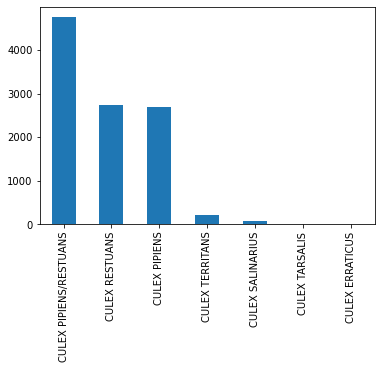

In [6]:
#how many mosquitos of each species are in the dataset?

train_clean['species'].value_counts(ascending=False).plot(kind='bar');

We can see that there are 7 species of mosquitos observed in the dataset. Out of which 3 species are observed more frequently than the others. Namely: Culex Pipiens/Restuans, Culex Restuans and Culex Pipiens. 

In [7]:
# which species of mosquitos carry the West Nile Virus?

train_clean.loc[train_clean['wnvpresent']==1]['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS'],
      dtype=object)

In [8]:
# proportion of species that carry the virus?
train_clean.loc[train_clean['wnvpresent']==1]['species'].value_counts(ascending=False)

CULEX PIPIENS/RESTUANS    262
CULEX PIPIENS             240
CULEX RESTUANS             49
Name: species, dtype: int64

<AxesSubplot:>

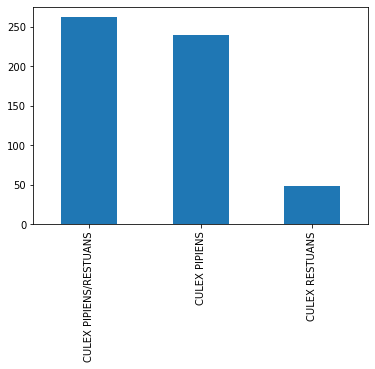

In [9]:
train_clean.loc[train_clean['wnvpresent']==1]['species'].value_counts(ascending=False).plot(kind="bar")

We can see that there are 3 species which carry the west nile virus, which coincidentally also have the highest number of observations compared to other mosquito species. For the purposes of modelling, we will be transforming species into an ordinal feature, based on proportion. 

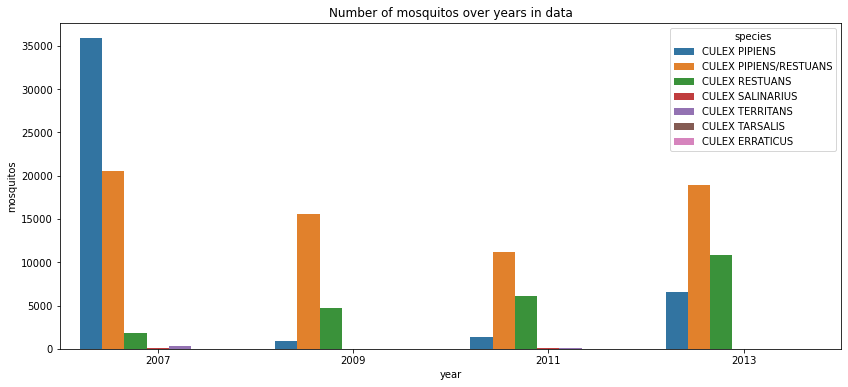

In [10]:
# mosquito population over the years
# charting mosquitos by year

train_clean['date'] = pd.to_datetime(train_clean['date'], format='%Y-%m-%d') #convert date to datetime object

train_clean['year'] = (train_clean['date'].dt.strftime('%Y')).astype(int) #create year column in dataset

mosq_by_yr = train_clean.groupby(['year', 'species'], as_index=False).sum().reindex()

plt.figure(figsize = (14,6))
plt.title('Number of mosquitos over years in data')
sns.barplot(x='year', y='nummosquitos', hue='species', data=mosq_by_yr)
plt.xlabel('year')
plt.ylabel('mosquitos'); 

Mosquito population was highest in the year 2007 with the species Culex Pipiens having the highest population. However, the overall mosquito population decreased in 2009 and 2011, and Culex Pipens/Restuans became the species with the highest population. 

In 2013, the population of mosquitos seem to have started increasing again.

### WNV cases by month

Since we have converted our date column into a date time object, we can now look at plotting wnv cocurrences by month for each year in the data. We can see in the line chart below that the wnv cases peak in August for each year and that there seems to be a high number of cases in 2013 compared to the rest of the years, even though the mosquito population has dropped drastically after 2007.

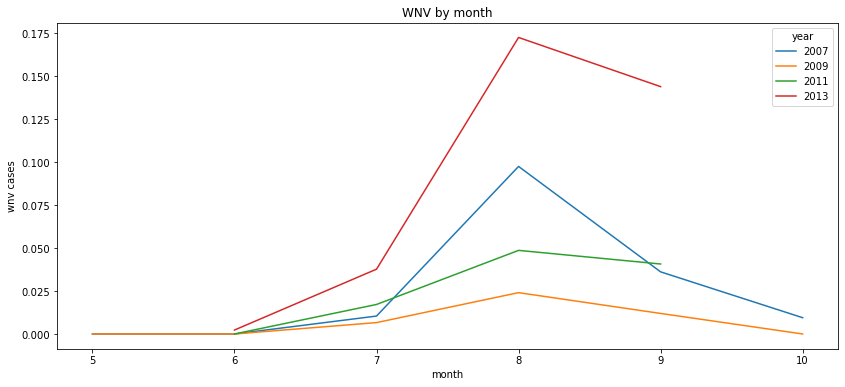

In [18]:
train_clean['month'] = (train_clean['date'].dt.strftime('%m')).astype(int) #create year column in dataset

wnv_by_mth = train_clean[['wnvpresent','year', 'month']]

plt.figure(figsize=(14,6))
sns.lineplot(x=wnv_by_mth.month, y='wnvpresent', data=wnv_by_mth, hue='year', palette='tab10', ci=None)
plt.title('WNV by month')
plt.xlabel('month')
plt.ylabel('wnv cases');

### Traps

We explore traps because they are proxies for locations, and they also contain relevant information on mosquitos species and number of mosquitos trapped over the years.

In [19]:
# how many traps are there?

train_clean['trap'].nunique()

136

In [20]:
#which traps have recorded the highest number of mosquitos?
train_clean.groupby(['trap', 'street'])['nummosquitos'].sum().sort_values(ascending=False)

trap  street             
T115   S DOTY AVE            21668
T900   W OHARE AIRPORT       15386
T138   S STONY ISLAND AVE     9936
T002   N OAK PARK AVE         3710
T128   E 105TH ST             3315
                             ...  
T072   S KEDZIE AVE             19
T237   W 85TH ST                18
T078   S RACINE AVE             17
T149   W GRANVILLE AVE          15
T040   S HAMLIN AVE              6
Name: nummosquitos, Length: 138, dtype: int64

<AxesSubplot:>

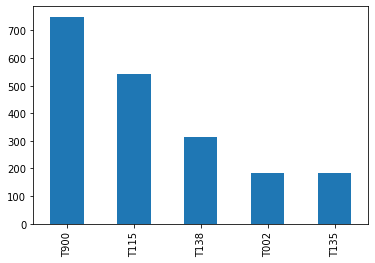

In [21]:
# which traps have been most sampled?  

train_clean['trap'].value_counts(ascending=False).head().plot(kind='bar')

Thus far, we see that S Doty Ave and W Ohare Airport seem to be the 2 most frequently sampled locations, and traps in these 2 locations (T115 and T900) have captured the highest number of mosquitos over the years.

## Preliminary feature combination and selection

There are 3 main steps in this process which we will need to do before combining the train dataset with other datasets for further EDA, feature selection and modelling. <br>

1) **Drop all address-related rows**: Retain latitude and longitude <br>
2) **Combine rows for same date, trap, species**: Sum up nummosquito over date & location & species <br>
3) **Group up species**: Make ordinal based on proportion of wnv within species <br>




### Drop address related rows

We have latitude, longitude and traps that are proxies/indicators of location. As such, we will remove the other address or location related features from the dataset.

In [22]:
address_features = ['address', 'block', 'street', 'addressnumberandstreet', 'addressaccuracy']
train_clean.drop(columns=address_features,inplace=True)
train_clean.head()

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2007,5
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,2007,5
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,2007,5
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,2007,5
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,2007,5


### Combining mosquito counts

We know that the dataset is organized such that the number of mosquitos captured is capped at 50 per record. Beyond 50, another row will be created for data collected on the same day. We will therefore explore combining the dataset rows together.

In [23]:
train_clean.loc[train_clean['nummosquitos']==50]

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month
293,2007-07-11,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,50,0,2007,7
295,2007-07-11,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,50,0,2007,7
350,2007-07-11,CULEX PIPIENS/RESTUANS,T158,41.682587,-87.707973,50,0,2007,7
351,2007-07-11,CULEX PIPIENS/RESTUANS,T158,41.682587,-87.707973,50,0,2007,7
353,2007-07-11,CULEX PIPIENS/RESTUANS,T158,41.682587,-87.707973,50,0,2007,7
...,...,...,...,...,...,...,...,...,...
10240,2013-09-12,CULEX PIPIENS/RESTUANS,T115,41.673408,-87.599862,50,1,2013,9
10242,2013-09-12,CULEX PIPIENS/RESTUANS,T115,41.673408,-87.599862,50,0,2013,9
10259,2013-09-12,CULEX PIPIENS/RESTUANS,T900,41.974689,-87.890615,50,0,2013,9
10262,2013-09-12,CULEX PIPIENS/RESTUANS,T900,41.974689,-87.890615,50,0,2013,9


In [24]:
#combining rows

train_clean = train_clean.groupby([col for col in train_clean.columns if col not in ['nummosquitos']], as_index=False).sum().reindex()


### Group up species and convert species into ordinal features

Earlier, we mentioned that we will convert mosquito species into ordinal features by proportion.

<AxesSubplot:>

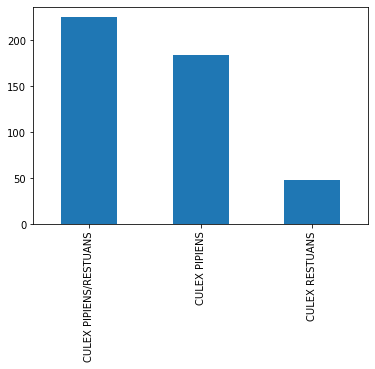

In [25]:
#recap of mosquito species carrying the west nile virus

train_clean.loc[train_clean['wnvpresent']==1]['species'].value_counts(ascending=False).plot(kind="bar")

Culex pipiens/restuans and Culex pipiens will take the value of 2 as they seem to have similar proportions in terms of carrying the west nile virus. Culex restuans will take the value of 1, and other mosquito species will take the value of 0.

In [26]:
train_clean['species_ord'] = train_clean['species'].map({'CULEX PIPIENS/RESTUANS': 2, 'CULEX PIPIENS': 2, 'CULEX RESTUANS': 1})

#0 for species other than the virus carriers
train_clean['species_ord'].fillna(0, inplace=True)

In [27]:
train_clean.head()

,date,species,trap,latitude,longitude,wnvpresent,year,month,nummosquitos,species_ord
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,0,2007,5,1,2.0
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,0,2007,5,1,2.0
2,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,0,2007,5,1,2.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,0,2007,5,1,2.0
4,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,0,2007,5,1,2.0


In [28]:
#save final train file to csv
train_clean.to_csv('../../data/train_eng_kev.csv')